# **Лабораторная работа №3**
**Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.**
<hr></hr>

**<h2>Задание:</h2>**
  


1.  Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2.   В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3.   С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4.   Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью подходящих для задачи метрик.
5.   Произведите подбор гиперпараметра K с использованием GridSearchCV и RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели. Используйте не менее двух стратегий кросс-валидации.
6.   Сравните метрики качества исходной и оптимальной моделей.
<hr></hr>

# **Ход работы**
Возьмем датасет *BostonHousing* (https://www.kaggle.com/code/ankurchavan/bostonhousing)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
hdata_loaded = pd.read_csv('BostonHousing.csv', sep=",")
hdata_loaded.shape

(506, 14)

In [ ]:
hdata_loaded.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
list(zip(hdata_loaded.columns, [i for i in hdata_loaded.dtypes]))

[('crim', dtype('float64')),
 ('zn', dtype('float64')),
 ('indus', dtype('float64')),
 ('chas', dtype('int64')),
 ('nox', dtype('float64')),
 ('rm', dtype('float64')),
 ('age', dtype('float64')),
 ('dis', dtype('float64')),
 ('rad', dtype('int64')),
 ('tax', dtype('int64')),
 ('ptratio', dtype('float64')),
 ('b', dtype('float64')),
 ('lstat', dtype('float64')),
 ('medv', dtype('float64'))]

In [ ]:
hdata = hdata_loaded
hcols_with_na = [c for c in hdata.columns if hdata[c].isnull().sum() > 0]
hcols_with_na


['rm']

In [ ]:
[(c, hdata[c].isnull().mean()) for c in hcols_with_na]

[('rm', np.float64(0.009881422924901186))]

In [ ]:
hdata['rm'] = hdata['rm'].fillna(hdata['rm'].mode()[0])
print('Кол-во пропусков =', hdata['rm'].isnull().sum())

Кол-во пропусков = 0


<hr></hr>
С использованием метода train_test_split разделим выборку на обучающую и тестовую.

In [ ]:
from sklearn.model_selection import train_test_split

X = hdata.drop('medv', axis=1)
y = hdata['medv']  # Целевая переменная

# Проверяем размерности
print(f"Размер X: {X.shape}")
print(f"Размер y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"Обучающая выборка: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Тестовая выборка: X_test = {X_test.shape}, y_test = {y_test.shape}")


Размер X: (506, 13)
Размер y: (506,)
Обучающая выборка: X_train = (404, 13), y_train = (404,)
Тестовая выборка: X_test = (102, 13), y_test = (102,)


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Создаем модель KNN для регрессии
knn = KNeighborsRegressor(n_neighbors=5)  # K=5

# Обучаем модель на тренировочных данных
knn.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = knn.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f} Средний квадрат ошибки")
print(f"MAE: {mae:.2f} Средняя ошибка")
print(f"R²: {r2:.2f} Дисперсия целевой переменной")

MSE: 25.86 Средний квадрат ошибки
MAE: 3.66 Средняя ошибка
R²: 0.65 Дисперсия целевой переменной


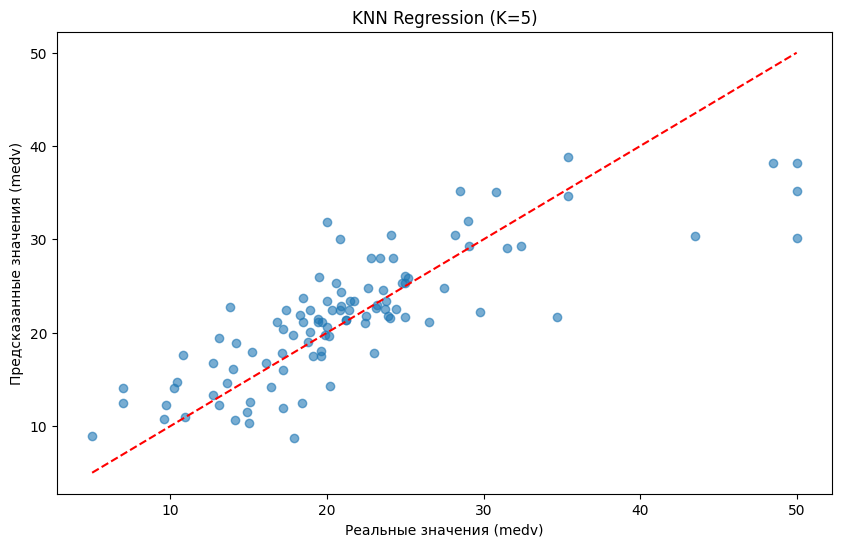

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Идеальная линия
plt.xlabel('Реальные значения (medv)')
plt.ylabel('Предсказанные значения (medv)')
plt.title('KNN Regression (K=5)')
plt.show()

# **GridSearchCV + K-Fold**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, ShuffleSplit
# Параметры для перебора
param_grid = {'n_neighbors': np.arange(1, 31)}  # K от 1 до 30

# Создаем модель
knn = KNeighborsRegressor()

# GridSearchCV с K-Fold
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),  # 5-fold кросс-валидация
    scoring='neg_mean_squared_error',  # Минимизируем MSE
    n_jobs=-1
)

# Запуск поиска
grid_search.fit(X_train, y_train)

# Лучший параметр
best_k_grid = grid_search.best_params_['n_neighbors']
print(f"Оптимальное K (GridSearchCV + K-Fold): {best_k_grid}")


Оптимальное K (GridSearchCV + K-Fold): 4


# **GridSearchCV + ShuffleSplit**

In [ ]:
grid_search_shuffle = GridSearchCV(
    knn,
    param_grid,
    cv=ShuffleSplit(n_splits=5, test_size=0.2, random_state=42),  # 5 итераций, 20% тест
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search_shuffle.fit(X_train, y_train)
best_k_grid_shuffle = grid_search_shuffle.best_params_['n_neighbors']
print(f"Оптимальное K (GridSearchCV + ShuffleSplit): {best_k_grid_shuffle}")

Оптимальное K (GridSearchCV + ShuffleSplit): 2


# **RandomizedSearchCV + K-Fold**

In [ ]:
random_search = RandomizedSearchCV(
    knn,
    param_distributions={'n_neighbors': np.arange(1, 31)},
    n_iter=15,  # Количество случайных комбинаций
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
best_k_random = random_search.best_params_['n_neighbors']
print(f"Оптимальное K (RandomizedSearchCV + K-Fold): {best_k_random}")

Оптимальное K (RandomizedSearchCV + K-Fold): 5


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

# Оригинальная модель (K=5)
knn_base = KNeighborsRegressor(n_neighbors=5)
knn_base.fit(X_train, y_train)
y_pred_base = knn_base.predict(X_test)
mse_original = mean_squared_error(y_test, y_pred_base)
r2_original = r2_score(y_test, y_pred_base)

# Лучшая модель из GridSearchCV (K-Fold)
knn_grid = KNeighborsRegressor(n_neighbors=best_k_grid)
knn_grid.fit(X_train, y_train)
y_pred_grid = knn_grid.predict(X_test)
mse_grid = mean_squared_error(y_test, y_pred_grid)
r2_grid = r2_score(y_test, y_pred_grid)

# Лучшая модель из GridSearchCV (ShuffleSplit)
knn_grid_shuffle = KNeighborsRegressor(n_neighbors=best_k_grid_shuffle)
knn_grid_shuffle.fit(X_train, y_train)
y_pred_grid_shuffle = knn_grid_shuffle.predict(X_test)
mse_grid_shuffle = mean_squared_error(y_test, y_pred_grid_shuffle)
r2_grid_shuffle = r2_score(y_test, y_pred_grid_shuffle)

# Лучшая модель из RandomizedSearchCV
knn_random = KNeighborsRegressor(n_neighbors=best_k_random)
knn_random.fit(X_train, y_train)
y_pred_random = knn_random.predict(X_test)
mse_random = mean_squared_error(y_test, y_pred_random)
r2_random = r2_score(y_test, y_pred_random)

# Формируем таблицу результатов
results = pd.DataFrame({
    'Модель': [
        'Исходная (K=5)',
        'GridSearchCV (K-Fold)',
        'GridSearchCV (ShuffleSplit)',
        'RandomizedSearchCV'
    ],
    'K': [5, best_k_grid, best_k_grid_shuffle, best_k_random],
    'MSE': [mse_original, mse_grid, mse_grid_shuffle, mse_random],
    'R²': [r2_original, r2_grid, r2_grid_shuffle, r2_random]
})

print(results)


                        Модель  K        MSE        R²
0               Исходная (K=5)  5  25.860125  0.647364
1        GridSearchCV (K-Fold)  4  24.088223  0.671526
2  GridSearchCV (ShuffleSplit)  2  32.599461  0.555465
3           RandomizedSearchCV  5  25.860125  0.647364


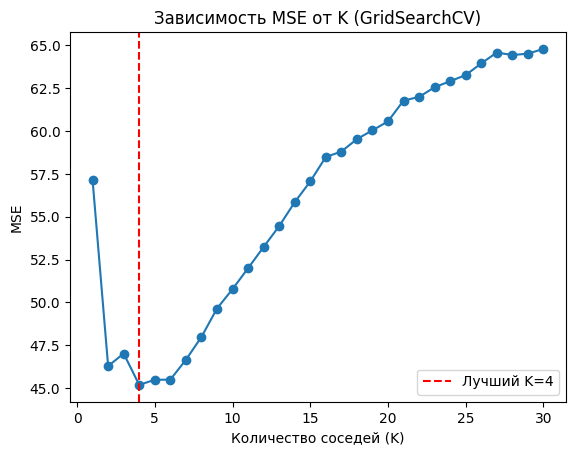

In [ ]:
plt.plot(param_grid['n_neighbors'], -grid_search.cv_results_['mean_test_score'], marker='o')
plt.xlabel('Количество соседей (K)')
plt.ylabel('MSE')
plt.title('Зависимость MSE от K (GridSearchCV)')
plt.axvline(best_k_grid, color='r', linestyle='--', label=f'Лучший K={best_k_grid}')
plt.legend()
plt.show()

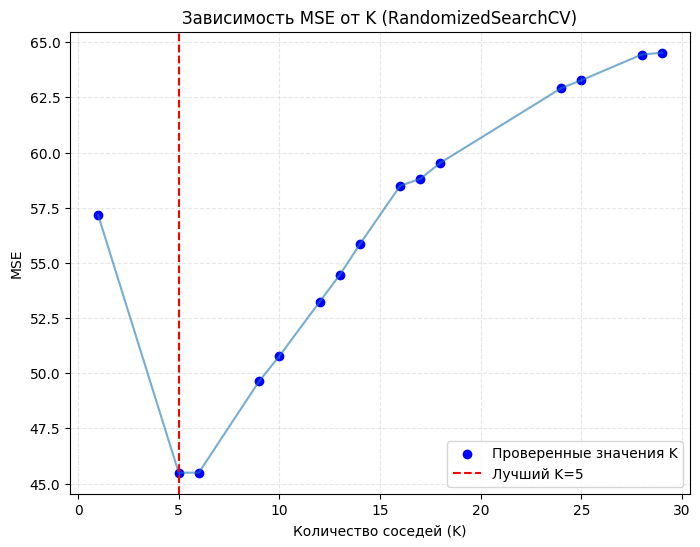

In [ ]:
# Достаем значения K, которые проверял RandomizedSearchCV
tested_k_values = random_search.cv_results_['param_n_neighbors'].data
mean_test_scores = -random_search.cv_results_['mean_test_score']  # MSE (из отрицательного в положительный)

# Создаем график
plt.figure(figsize=(8, 6))

# Точки для каждого проверенного K
plt.scatter(tested_k_values, mean_test_scores, color='blue', marker='o', label='Проверенные значения K')

# Линия тренда для наглядности
plt.plot(sorted(tested_k_values), [mean_test_scores[i] for i in np.argsort(tested_k_values)], linestyle='-', alpha=0.6)

# Линия лучшего K
plt.axvline(best_k_random, color='r', linestyle='--', label=f'Лучший K={best_k_random}')

# Подписи осей и заголовок
plt.xlabel('Количество соседей (K)')
plt.ylabel('MSE')
plt.title('Зависимость MSE от K (RandomizedSearchCV)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()


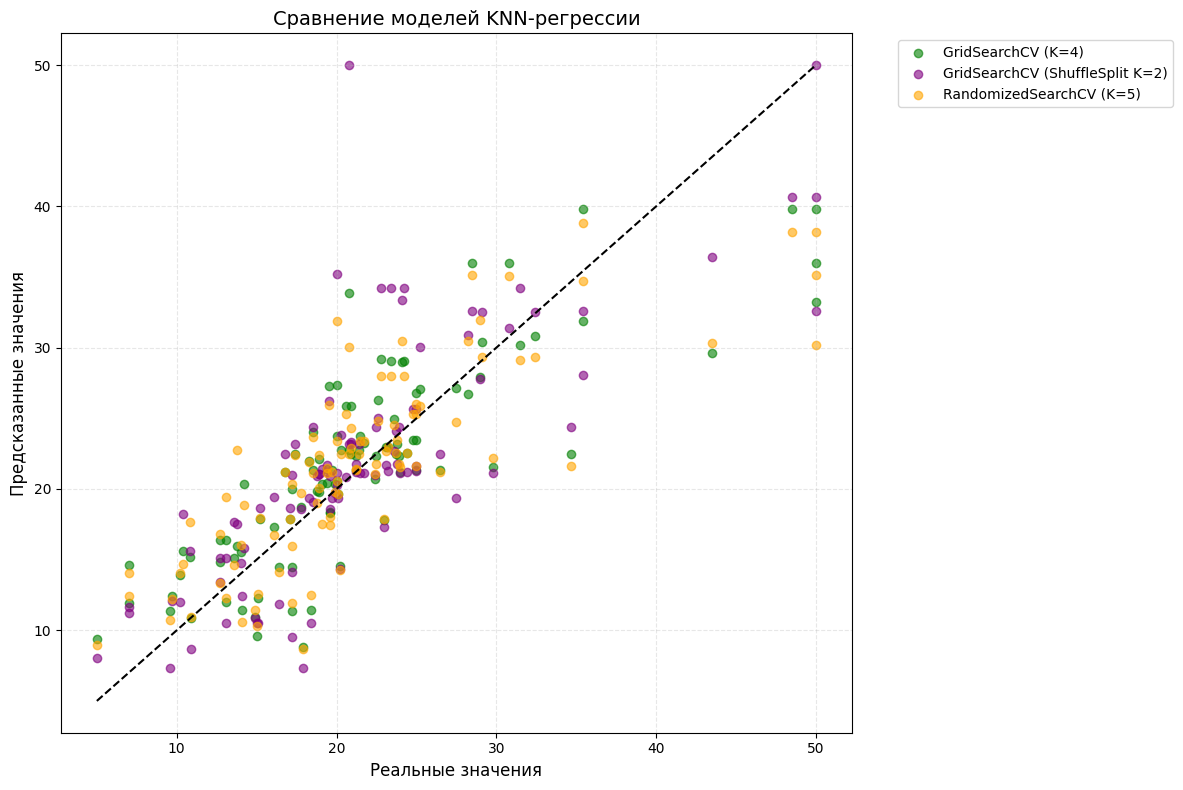

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Оптимальная модель (GridSearchCV K-Fold)
plt.scatter(y_test, y_pred_grid, alpha=0.6, color='green', label=f'GridSearchCV (K={best_k_grid})')

# Оптимальная модель (GridSearchCV ShuffleSplit)
plt.scatter(y_test, y_pred_grid_shuffle, alpha=0.6, color='purple', label=f'GridSearchCV (ShuffleSplit K={best_k_grid_shuffle})')

# Оптимальная модель (RandomizedSearchCV)
plt.scatter(y_test, y_pred_random, alpha=0.6, color='orange', label=f'RandomizedSearchCV (K={best_k_random})')

# Идеальная линия
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')

# Настройки графика
plt.xlabel('Реальные значения', fontsize=12)
plt.ylabel('Предсказанные значения', fontsize=12)
plt.title('Сравнение моделей KNN-регрессии', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()
